In [1]:
# 📌 Cell 1: Import Libraries & Load Data

# Import libraries for saving/loading models and optimization
import joblib  # For saving and loading trained models
import optuna  # For hyperparameter optimization
import time  # To measure execution time

# Import core libraries for numerical and data handling
import numpy as np  # For numerical operations
import pandas as pd  # For handling and processing datasets

# Import visualization libraries
import seaborn as sns  # For visualizing data distributions
import matplotlib.pyplot as plt  # For plotting graphs and charts

# Import machine learning classifiers
from sklearn.ensemble import RandomForestClassifier, StackingClassifier  # Random Forest and Stacking models
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from xgboost import XGBClassifier  # XGBoost Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors model
from sklearn.naive_bayes import MultinomialNB  # Naïve Bayes model for text classification

# Import model selection and validation tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score  # Data splitting and cross-validation

# Import performance evaluation metrics
from sklearn.metrics import (
    accuracy_score,  # Calculates accuracy
    classification_report,  # Provides precision, recall, F1-score
    precision_recall_fscore_support,  # Additional precision, recall, F1-score metrics
    confusion_matrix  # Generates confusion matrix for evaluating classification performance
)

# Import feature extraction techniques
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text into TF-IDF vectors
from sentence_transformers import SentenceTransformer  # Generates embeddings using pre-trained transformer models

# Import techniques for handling imbalanced datasets
from imblearn.over_sampling import ADASYN, SMOTE  # Oversampling methods for balancing dataset
from sklearn.utils.class_weight import compute_sample_weight  # Computes sample weights for imbalanced datasets

# Import feature selection utilities
from sklearn.feature_selection import SelectFromModel  # Selects important features from a trained model
from scipy.sparse import csr_matrix  # Handles sparse matrices efficiently (used in TF-IDF and embeddings)

# 📌 Load Preprocessed Dataset
# Read the cleaned and merged dataset from a CSV file
merged_df = pd.read_csv("Multiclass_dataset/cleaned_merged_dataset.csv")

# 📌 Combine Headline + Body text
# Concatenates the "Headline" and "articleBody" columns to form a single text feature
merged_df["combined_text"] = merged_df["Headline"] + " " + merged_df["articleBody"]

# 📌 Manual Label Mapping (Ensures Correct Alignment)
# Define a mapping dictionary to convert categorical labels into numeric values
label_mapping = {"agree": 0, "disagree": 1, "discuss": 2, "unrelated": 3}

# Create an inverse mapping (to convert numbers back to labels if needed)
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Apply the label mapping to convert text labels into numerical format
merged_df["Stance"] = merged_df["Stance"].map(label_mapping)


In [2]:
# 📌 Cell 2: Feature Extraction with TF-IDF

# ✅ Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    stop_words="english",  # Removes common English stopwords to improve efficiency
    max_features=10000,  # Limits the number of features to the top 10,000 most important words/phrases
    ngram_range=(1, 3)  # Considers unigrams, bigrams, and trigrams
)

# ✅ Apply TF-IDF transformation to the combined text feature
X = tfidf.fit_transform(merged_df["combined_text"])  # Converts text into a sparse matrix of TF-IDF features

# ✅ Save the TF-IDF Vectorizer for future use
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")
print("💾 TF-IDF Vectorizer saved to models/tfidf_vectorizer.pkl")

# ✅ Extract target labels (Stance) for classification
y = merged_df["Stance"]


💾 TF-IDF Vectorizer saved to models/tfidf_vectorizer.pkl


In [3]:
# 📌 Cell 3: Train-Test Split & ADASYN Oversampling

# ✅ Train-Test Split using TF-IDF transformed data
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Feature matrix (TF-IDF transformed text)
    y,  # Target labels (Stance classification)
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42,  # Ensures reproducibility of results
    stratify=y  # Ensures proportional distribution of stance labels in train and test sets
)

# ✅ Apply ADASYN to TF-IDF transformed features
adasyn = ADASYN(
    sampling_strategy="not majority",  # Ensures only the minority classes are oversampled
    random_state=42  # Ensures reproducibility of synthetic sample generation
)

# Perform oversampling on the training set to balance class distribution
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# ✅ Convert X_train_balanced back to a sparse matrix
X_train_balanced = csr_matrix(X_train_balanced)  # Converts the resampled data back to a sparse format to save memory

# ✅ Save the balanced dataset for future use
joblib.dump(X_train_balanced, "models/X_train_balanced.pkl")
joblib.dump(y_train_balanced, "models/y_train_balanced.pkl")
print("💾 Balanced training dataset saved.")

# ✅ Check new class distribution
print(pd.Series(y_train_balanced).value_counts())  # Prints class distribution after ADASYN


💾 Balanced training dataset saved.
Stance
0    29293
3    29011
1    29011
2    28750
Name: count, dtype: int64


C:\Users\gohna\AppData\Local\Temp\ipykernel_11976\994171656.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2")  # Plot class distribution using Seaborn countplot


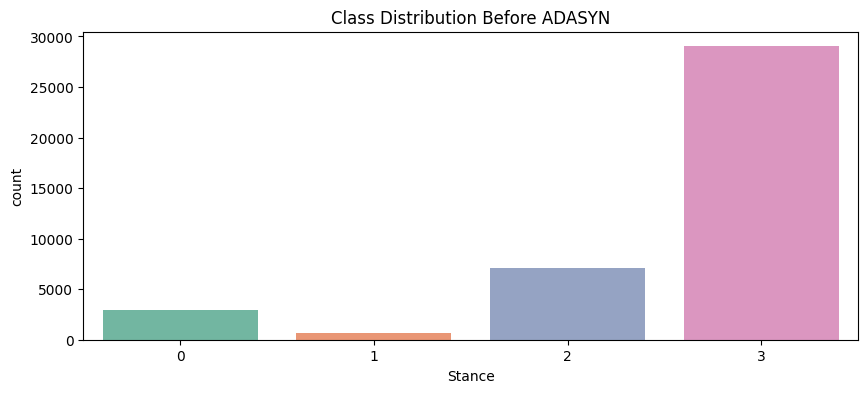

C:\Users\gohna\AppData\Local\Temp\ipykernel_11976\994171656.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_balanced, palette="Set1")  # Plot class distribution after applying ADASYN


💾 Class distribution before ADASYN saved.


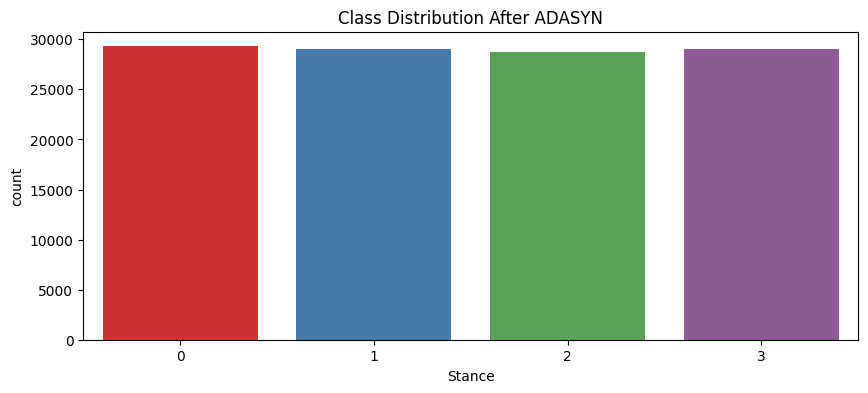

💾 Class distribution after ADASYN saved.


In [4]:
# 📌 Cell 4: Class Distribution Visualization

# ✅ Class Distribution Before ADASYN
plt.figure(figsize=(10, 4))  # Set figure size for better visibility
sns.countplot(x=y_train, palette="Set2")  # Plot class distribution using Seaborn countplot
plt.title("Class Distribution Before ADASYN")  # Add title for clarity
plt.show()  # Display the plot

# ✅ Save Class Distribution Before ADASYN
pd.Series(y_train).value_counts().to_csv("models/class_distribution_before_adasyn.csv")
print("💾 Class distribution before ADASYN saved.")

# ✅ Class Distribution After ADASYN
plt.figure(figsize=(10, 4))  # Set figure size for better visibility
sns.countplot(x=y_train_balanced, palette="Set1")  # Plot class distribution after applying ADASYN
plt.title("Class Distribution After ADASYN")  # Add title for clarity
plt.show()  # Display the plot

# ✅ Save Class Distribution After ADASYN
pd.Series(y_train_balanced).value_counts().to_csv("models/class_distribution_after_adasyn.csv")
print("💾 Class distribution after ADASYN saved.")


⏳ Random Forest Training Time: 45.41 seconds
💾 Random Forest Model and Feature Selector saved.
✅ Random Forest Test Accuracy: 0.8690
              precision    recall  f1-score   support

       agree       0.49      0.70      0.57       729
    disagree       0.35      0.48      0.41       166
     discuss       0.81      0.74      0.78      1766
   unrelated       0.96      0.93      0.94      7253

    accuracy                           0.87      9914
   macro avg       0.65      0.71      0.67      9914
weighted avg       0.89      0.87      0.88      9914



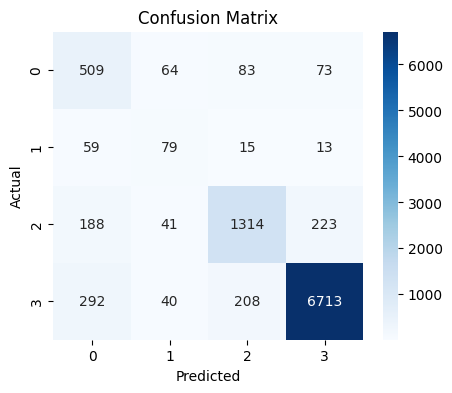

In [5]:
# 📌 Cell 5: Train Optimized Random Forest & Feature Selection

# ✅ Start training timer
start_time = time.time()  # Records the start time for measuring training duration

# ✅ Initialize Random Forest Classifier with optimized hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=300,  # Number of trees in the forest
    max_depth=20,  # Maximum depth of each tree (limits overfitting)
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    min_samples_leaf=2,  # Minimum number of samples required at a leaf node
    max_features="sqrt",  # Uses the square root of the total features per tree split
    class_weight="balanced",  # Adjusts class weights to handle imbalanced data
    random_state=42,  # Ensures reproducibility
    n_jobs=-1  # Uses all available CPU cores for faster training
)

# ✅ Train the Random Forest model on the balanced dataset
rf_model.fit(X_train_balanced, y_train_balanced)

# ✅ Calculate training time
rf_train_time = time.time() - start_time  # Compute total training time
print(f"⏳ Random Forest Training Time: {rf_train_time:.2f} seconds")  # Display training time

# ✅ Feature Selection using the trained model
feature_selector = SelectFromModel(rf_model, threshold="mean")  # Select features based on importance scores
X_train_selected = feature_selector.transform(X_train_balanced)  # Apply feature selection to the training set
X_test_selected = feature_selector.transform(X_test)  # Apply feature selection to the test set

# ✅ Save the trained Random Forest model and Feature Selector
joblib.dump((rf_model), "models/rf_model.pkl")
joblib.dump(feature_selector, "models/feature_selector.pkl")
print("💾 Random Forest Model and Feature Selector saved.")

# ✅ Retrain the Random Forest model with selected features
rf_model.fit(X_train_selected, y_train_balanced)

# ✅ Make Predictions on the Test Set
y_pred_rf = rf_model.predict(X_test_selected)  # Predict class labels for the test set

# ✅ Convert numerical predictions back to original labels
y_pred_labels_rf = pd.Series(y_pred_rf).map(inverse_label_mapping)  # Convert predicted values to labels
y_test_labels = pd.Series(y_test).map(inverse_label_mapping)  # Convert test set labels back to original format

# ✅ Evaluate the Random Forest Model
print(f"✅ Random Forest Test Accuracy: {accuracy_score(y_test_labels, y_pred_labels_rf):.4f}")  # Print test accuracy
print(classification_report(
    y_test_labels, y_pred_labels_rf,  # Compare true vs predicted labels
    target_names=list(label_mapping.keys()),  # Use original class labels for readability
    zero_division=0  # Avoid errors due to zero divisions
))

# ✅ Generate and Display Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels_rf)  # Compute confusion matrix
plt.figure(figsize=(5, 4))  # Set figure size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")  # Create heatmap visualization
plt.xlabel("Predicted")  # Label x-axis
plt.ylabel("Actual")  # Label y-axis
plt.title("Confusion Matrix")  # Add title
plt.show()  # Display the plot


Training Size: (104458, 10000), Validation Size: (11607, 10000)
[0]	validation_0-mlogloss:1.33625
[10]	validation_0-mlogloss:1.02763
[20]	validation_0-mlogloss:0.86723
[30]	validation_0-mlogloss:0.77294
[40]	validation_0-mlogloss:0.70640
[50]	validation_0-mlogloss:0.64933
[60]	validation_0-mlogloss:0.60560
[70]	validation_0-mlogloss:0.56655
[80]	validation_0-mlogloss:0.53411
[90]	validation_0-mlogloss:0.50588
[100]	validation_0-mlogloss:0.47740
[110]	validation_0-mlogloss:0.45456
[120]	validation_0-mlogloss:0.43419
[130]	validation_0-mlogloss:0.41615
[140]	validation_0-mlogloss:0.39717
[150]	validation_0-mlogloss:0.38187
[160]	validation_0-mlogloss:0.36625
[170]	validation_0-mlogloss:0.35193
[180]	validation_0-mlogloss:0.33829
[190]	validation_0-mlogloss:0.32480
[200]	validation_0-mlogloss:0.31282
[210]	validation_0-mlogloss:0.30209
[220]	validation_0-mlogloss:0.29058
[230]	validation_0-mlogloss:0.28058
[240]	validation_0-mlogloss:0.27173
[249]	validation_0-mlogloss:0.26309
⏳ XGBoost T

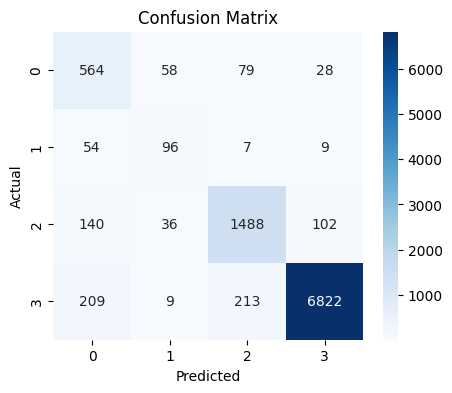

In [6]:
# 📌 Cell 6: XGBoost Training & Evaluation

# ✅ Import necessary libraries
from sklearn.model_selection import train_test_split  # Splitting data into train/test/validation
import time  # For measuring execution time
import numpy as np  # Numerical operations
import pandas as pd  # Data handling
from xgboost import XGBClassifier  # XGBoost classifier
from scipy.sparse import csr_matrix  # Sparse matrix format to save memory
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics

# ✅ Create a Validation Set from the Training Data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_balanced,  # Training features
    y_train_balanced,  # Training labels
    test_size=0.1,  # Use 10% of the training data for validation
    random_state=42,  # Ensures reproducibility
    stratify=y_train_balanced  # Ensures proportional distribution of classes
)

# ✅ Display Training and Validation Set Sizes
print(f"Training Size: {X_train_final.shape}, Validation Size: {X_val.shape}")

# ✅ Convert Data to Sparse Matrix (Saves Memory)
X_train_balanced = csr_matrix(X_train_balanced)  # Convert training data to sparse matrix format
X_test = csr_matrix(X_test)  # Convert test data to sparse matrix format

# ✅ Define Optimized XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=250,  # ✅ Reduce the number of trees to optimize training time
    learning_rate=0.09506484283779507,  # Controls step size at each boosting step
    max_depth=8,  # ✅ Limits tree depth to prevent overfitting
    min_child_weight=3,  # Minimum sum of instance weight needed in a child node
    gamma=0.1777302416003415,  # Controls tree split regularization
    subsample=0.657855522236526,  # ✅ Uses a fraction of data to prevent overfitting
    colsample_bytree=0.8988814540637224,  # Controls the number of features each tree considers
    eval_metric="mlogloss",  # Multi-class log loss as evaluation metric
    early_stopping_rounds=10,  # ✅ Stops training if validation loss doesn't improve after 10 rounds
    tree_method="hist",  # ✅ Uses histogram-based algorithm for memory efficiency
    random_state=42  # Ensures reproducibility
)

# ✅ Train XGBoost with Early Stopping
start_time = time.time()  # Start training timer

xgb_model.fit(
    X_train_final, y_train_final,  # Training data
    eval_set=[(X_val, y_val)],  # Validation data for early stopping
    verbose=10  # Display progress every 10 iterations
)

xgb_train_time = time.time() - start_time  # Calculate training time
print(f"⏳ XGBoost Training Time: {xgb_train_time:.2f} seconds")  # Display training duration

# ✅ Save the trained XGBoost model
joblib.dump((xgb_model), "models/xgb_model.pkl")
print("💾 XGBoost Model saved to models/xgb_model.pkl")

# ✅ Predict on Test Set
y_pred_xgb = xgb_model.predict(X_test)  # Generate predictions on test data

# ✅ Evaluate XGBoost Model Performance
print(f"✅ XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")  # Print accuracy score
print(classification_report(
    y_test, y_pred_xgb,  # Compare actual vs. predicted labels
    target_names=list(label_mapping.keys()),  # Use original class names for readability
    zero_division=0  # Prevent errors from zero division cases
))

# ✅ Generate and Display Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)  # Compute confusion matrix
plt.figure(figsize=(5, 4))  # Set figure size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")  # Create heatmap visualization
plt.xlabel("Predicted")  # Label x-axis
plt.ylabel("Actual")  # Label y-axis
plt.title("Confusion Matrix")  # Add title
plt.show()  # Display the plot


⏳ Decision Tree Training Time: 187.43 seconds
💾 Decision Tree Model saved to models/dt_model.pkl

========== MODEL EVALUATION ==========
Training Time: 187.4350 seconds

Test Accuracy: 0.8951


=========== CLASSIFICATION REPORT ===========

              precision    recall  f1-score   support

       agree       0.65      0.68      0.67       729
    disagree       0.40      0.43      0.42       166
     discuss       0.80      0.81      0.80      1766
   unrelated       0.96      0.95      0.95      7253

    accuracy                           0.90      9914
   macro avg       0.70      0.72      0.71      9914
weighted avg       0.90      0.90      0.90      9914


=========== CONFUSION MATRIX ===========



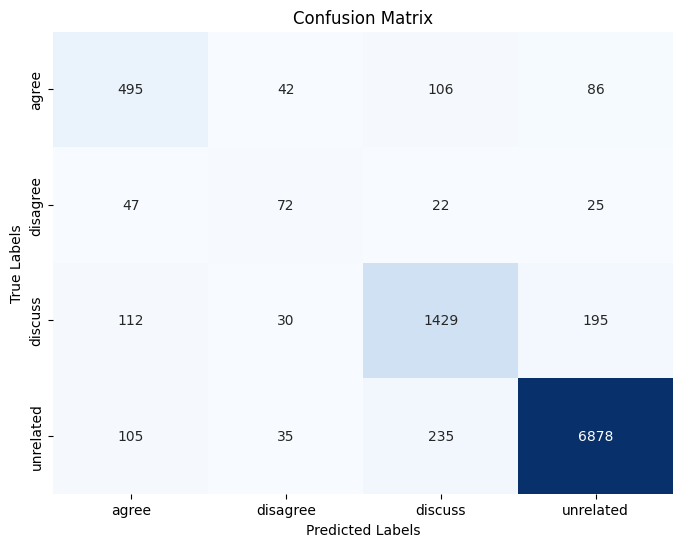

In [7]:
# 📌 Cell 7: Train Decision Tree

# ✅ Start timing the training process
start_time = time.time()  # Record the start time

# ✅ Initialize and train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)  # Set a fixed random state for reproducibility
dt_model.fit(X_train_balanced, y_train_balanced)  # ✅ Train the model

# ✅ End timing the training process
dt_train_time = time.time() - start_time  # Compute total training duration
print(f"⏳ Decision Tree Training Time: {dt_train_time:.2f} seconds")  # Display training duration

# ✅ Save the trained Decision Tree model
joblib.dump((dt_model), "models/dt_model.pkl")
print("💾 Decision Tree Model saved to models/dt_model.pkl")

# ✅ Predict on the test dataset (Note: The test set was not balanced)
y_pred = dt_model.predict(X_test)  # ✅ Use the trained model for prediction

# ✅ Compute Accuracy Score
accuracy = accuracy_score(y_test, y_pred)

# ✅ Compute Precision, Recall, F1-score, and Support (Per Class)
precision, recall, f1_score, support = precision_recall_fscore_support(
    y_test, y_pred, zero_division=0
)

# ✅ Generate a Classification Report
class_report = classification_report(y_test, y_pred, target_names=list(label_mapping.keys()), zero_division=0)

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Print Evaluation Metrics
print("\n========== MODEL EVALUATION ==========")
print(f"Training Time: {dt_train_time:.4f} seconds\n")
print(f"Test Accuracy: {accuracy:.4f}\n")
print("\n=========== CLASSIFICATION REPORT ===========\n")
print(class_report)

# ✅ Plot the Confusion Matrix
print("\n=========== CONFUSION MATRIX ===========\n")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=inverse_label_mapping.values(),
    yticklabels=inverse_label_mapping.values()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


⏳ KNN Training Time: 0.0754 seconds
💾 KNN Model saved to models/knn_model.pkl
⏳ KNN Prediction Time: 52.5150 seconds
✅ Test Accuracy: 0.8482

Classification Report:
              precision    recall  f1-score   support

       agree       0.47      0.69      0.56       729
    disagree       0.33      0.42      0.37       166
     discuss       0.68      0.86      0.76      1766
   unrelated       0.99      0.87      0.92      7253

    accuracy                           0.85      9914
   macro avg       0.62      0.71      0.65      9914
weighted avg       0.88      0.85      0.86      9914



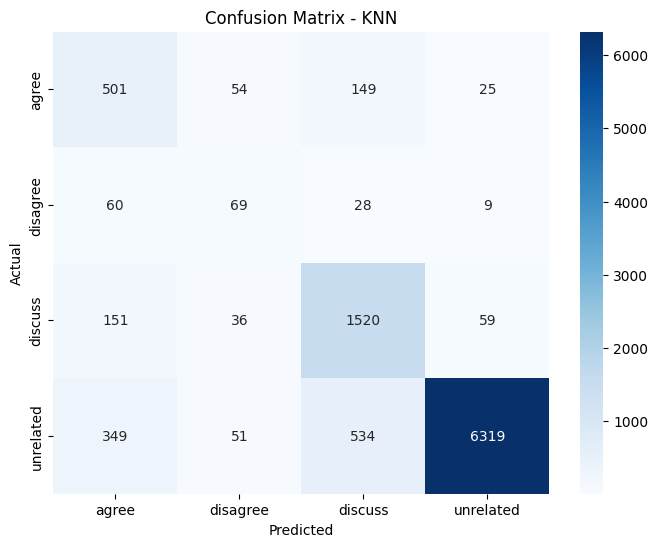

In [8]:
# 📌 Cell 8: Train K-Nearest Neighbors (KNN) Model

# ✅ Initialize KNN model with specified hyperparameters
knn = KNeighborsClassifier(
    n_neighbors=1,  # ✅ Uses 1 nearest neighbor for classification
    algorithm="brute",  # ✅ Uses brute-force search to find nearest neighbors
    metric="euclidean",  # ✅ Computes distances using Euclidean distance
    weights="uniform"  # ✅ Assigns equal weight to all neighbors
)

# ✅ Start timer to measure training time
start_train_time = time.time()  # Records the start time

# ✅ Train the KNN model on the balanced training set
knn.fit(X_train_balanced, y_train_balanced)

# ✅ Compute training time
knn_train_time = time.time() - start_train_time  # Compute time taken for training
print(f"⏳ KNN Training Time: {knn_train_time:.4f} seconds")  # Display training time

# ✅ Save the trained KNN model with training time
joblib.dump((knn), "models/knn_model.pkl")
print("💾 KNN Model saved to models/knn_model.pkl")

# ✅ Start timer to measure prediction time
start_pred_time = time.time()  # Records the start time

# ✅ Predict class labels for the test set
y_pred = knn.predict(X_test)

# ✅ Compute prediction time
prediction_time = time.time() - start_pred_time  # Compute time taken for predictions
print(f"⏳ KNN Prediction Time: {prediction_time:.4f} seconds")  # Display prediction time

# ✅ Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy score
print(f"✅ Test Accuracy: {accuracy:.4f}")  # Print accuracy

# ✅ Generate a Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_mapping.keys()), zero_division=0))  # Print precision, recall, F1-score per class

# ✅ Compute and Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)  # Compute confusion matrix

# ✅ Visualize the Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues",  # Create a heatmap for confusion matrix
    xticklabels=inverse_label_mapping.values(),  # Set X-axis labels
    yticklabels=inverse_label_mapping.values()   # Set Y-axis labels
)
plt.xlabel("Predicted")  # Label X-axis
plt.ylabel("Actual")  # Label Y-axis
plt.title("Confusion Matrix - KNN")  # Add title to the plot
plt.show()  # Display the plot


💾 Naïve Bayes Model saved to models/nb_model.pkl
⌛ Naïve Bayes Training Time: 240.57 seconds

✅ Naïve Bayes Test Accuracy: 0.4420

Classification Report:
               precision    recall  f1-score   support

       agree       0.17      0.40      0.24       729
    disagree       0.07      0.80      0.13       166
     discuss       0.34      0.56      0.42      1766
   unrelated       0.86      0.41      0.55      7253

    accuracy                           0.44      9914
   macro avg       0.36      0.54      0.34      9914
weighted avg       0.71      0.44      0.50      9914



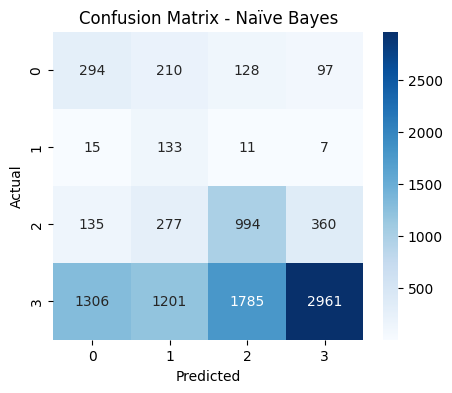

In [9]:
# 📌 Cell 9: Train Optimized Naïve Bayes Model

# ✅ Start timing the training process
nb_train_time = time.time()  # Records the start time

# ✅ Initialize the Multinomial Naïve Bayes model with specified hyperparameters
nb_model = MultinomialNB(
    alpha=1.0,  # ✅ Smoothing parameter (Laplace smoothing)
    fit_prior=True,  # ✅ Learn class prior probabilities from data
    class_prior=None  # ✅ Class priors are not manually specified, letting the model determine them
)

# ✅ Train the Naïve Bayes model on the balanced training set
nb_model.fit(X_train_balanced, y_train_balanced)

# ✅ Save the trained Naïve Bayes model
joblib.dump((nb_model), "models/nb_model.pkl")
print("💾 Naïve Bayes Model saved to models/nb_model.pkl")

# ✅ Calculate training time
nb_train_time = time.time() - start_time  # Compute total training duration
print(f"⌛ Naïve Bayes Training Time: {nb_train_time:.2f} seconds\n")  # Display training duration

# ✅ Make Predictions on the Test Set
y_pred = nb_model.predict(X_test)  # Generate predictions for the test set

# ✅ Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy score
print(f"✅ Naïve Bayes Test Accuracy: {accuracy:.4f}\n")  # Display test accuracy

# ✅ Generate a Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=list(label_mapping.keys()), zero_division=0))  # Print precision, recall, F1-score

# ✅ Compute and Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)  # Compute confusion matrix

# ✅ Visualize the Confusion Matrix using Seaborn
plt.figure(figsize=(5, 4))  # Set figure size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")  # Create a heatmap for confusion matrix
plt.xlabel("Predicted")  # Label X-axis
plt.ylabel("Actual")  # Label Y-axis
plt.title("Confusion Matrix - Naïve Bayes")  # Add title to the plot
plt.show()  # Display the plot

🔍 Debug: Training XGBoost Separately to Verify Functionality...
✅ XGBoost Standalone Accuracy: 0.8680
⏳ XGBoost Training Time: 707.85 seconds

🔍 Debug: Training Random Forest Separately to Verify Functionality...
✅ Random Forest Standalone Accuracy: 0.8695
⏳ Random Forest Training Time: 34.31 seconds


🚀 Training Stacking Model...
✅ Stacking Model Training Completed in 4260.42 seconds
💾 Stacking Classifier Model saved to models/stacking_model.pkl
🔍 Generating Predictions...
✅ Sample Predictions: [3 3 3 3 3 0 0 2 3 3]
✅ Stacked Model Accuracy: 0.8932
              precision    recall  f1-score   support

       agree       0.58      0.74      0.65       729
    disagree       0.47      0.52      0.49       166
     discuss       0.79      0.83      0.81      1766
   unrelated       0.97      0.93      0.95      7253

    accuracy                           0.89      9914
   macro avg       0.70      0.76      0.73      9914
weighted avg       0.90      0.89      0.90      9914



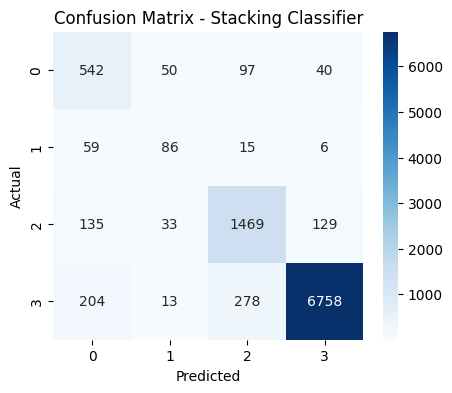


⏳ Training Time Summary:
🔹 XGBoost Training Time: 707.85 seconds
🔹 Random Forest Training Time: 34.31 seconds
🔹 Stacking Model Training Time: 4260.42 seconds
🔹 Prediction Time: 0.42 seconds
🚀 Total Time for Training & Prediction: 5002.99 seconds


In [10]:
# 📌 Cell 10: Stacking Classifier with XGBoost, Random Forest, and Logistic Regression

# ✅ Import necessary libraries
import time  # For measuring execution time
import numpy as np  # Numerical operations
import pandas as pd  # Data handling
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Plotting graphs
from sklearn.ensemble import RandomForestClassifier, StackingClassifier  # Random Forest & Stacking
from sklearn.linear_model import LogisticRegression  # Logistic Regression (meta-classifier)
from xgboost import XGBClassifier  # XGBoost Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics

# ✅ Step 1: Define XGBoost Model (Without Early Stopping for Stacking)
xgb_stacking_model = XGBClassifier(
    n_estimators=150,  # Number of boosting rounds
    learning_rate=0.09506484283779507,  # Step size shrinkage
    max_depth=8,  # Maximum tree depth
    min_child_weight=3,  # Minimum sum of instance weight in a child
    gamma=0.1777302416003415,  # Regularization parameter to control splits
    subsample=0.657855522236526,  # Fraction of samples used for training trees
    colsample_bytree=0.8988814540637224,  # Fraction of features used per tree
    eval_metric="mlogloss",  # Multi-class log loss as evaluation metric
    tree_method="hist",  # Optimized histogram-based algorithm for efficiency
    random_state=42  # Ensures reproducibility
)

# ✅ Step 2: Train XGBoost Separately for Debugging
print("🔍 Debug: Training XGBoost Separately to Verify Functionality...")
start_xgb = time.time()  # Start timing
xgb_stacking_model.fit(X_train_balanced, y_train_balanced)  # Train the model
xgb_train_time = time.time() - start_xgb  # Calculate training time
xgb_preds = xgb_stacking_model.predict(X_test)  # Generate predictions
print(f"✅ XGBoost Standalone Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")  # Display accuracy
print(f"⏳ XGBoost Training Time: {xgb_train_time:.2f} seconds\n")  # Display training time

# ✅ Step 3: Train Random Forest Separately for Debugging
rf_model = RandomForestClassifier(
    n_estimators=200,  # Number of trees in the forest
    max_depth=20,  # Maximum tree depth to prevent overfitting
    min_samples_split=10,  # Minimum samples required to split a node
    min_samples_leaf=2,  # Minimum samples per leaf node
    max_features="sqrt",  # Number of features per split (square root of total)
    class_weight="balanced",  # Adjusts class weights to handle imbalance
    random_state=42,  # Ensures reproducibility
    n_jobs=-1  # Uses all available CPU cores for faster training
)
print("🔍 Debug: Training Random Forest Separately to Verify Functionality...")
start_rf = time.time()  # Start timing
rf_model.fit(X_train_balanced, y_train_balanced)  # Train the model
rf_train_time = time.time() - start_rf  # Calculate training time
rf_preds = rf_model.predict(X_test)  # Generate predictions
print(f"✅ Random Forest Standalone Accuracy: {accuracy_score(y_test, rf_preds):.4f}")  # Display accuracy
print(f"⏳ Random Forest Training Time: {rf_train_time:.2f} seconds\n")  # Display training time

# ✅ Step 4: Define Stacking Classifier (Combining XGBoost & Random Forest)
stacked_model = StackingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_stacking_model)],  # Base learners
    final_estimator=LogisticRegression()  # Meta-classifier to make final decision
)

# ✅ Step 5: Train Stacking Model
print("\n🚀 Training Stacking Model...")
start_stacking = time.time()  # Start timing
stacked_model.fit(X_train_balanced, y_train_balanced)  # Train the stacked model
stacking_train_time = time.time() - start_stacking  # Calculate training time
print(f"✅ Stacking Model Training Completed in {stacking_train_time:.2f} seconds")  # Display training time

# ✅ Save the trained Stacking Classifier model
joblib.dump((stacked_model), "models/stacking_model.pkl")
print("💾 Stacking Classifier Model saved to models/stacking_model.pkl")

# ✅ Step 6: Generate Predictions using Stacking Model
print("🔍 Generating Predictions...")
start_prediction = time.time()  # Start timing
stacked_preds = stacked_model.predict(X_test)  # Predict on test data
prediction_time = time.time() - start_prediction  # Calculate prediction time

# ✅ Step 7: Debug: Check if Predictions Exist
print(f"✅ Sample Predictions: {stacked_preds[:10]}")  # Display first 10 predictions

# ✅ Step 8: Evaluate Stacking Model
print(f"✅ Stacked Model Accuracy: {accuracy_score(y_test, stacked_preds):.4f}")  # Display accuracy
print(classification_report(y_test, stacked_preds, target_names=list(label_mapping.keys()), zero_division=0))  # Print classification report

# ✅ Step 9: Generate and Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, stacked_preds)  # Compute confusion matrix
plt.figure(figsize=(5, 4))  # Set figure size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")  # Create heatmap visualization
plt.xlabel("Predicted")  # Label x-axis
plt.ylabel("Actual")  # Label y-axis
plt.title("Confusion Matrix - Stacking Classifier")  # Add title
plt.show()  # Display the plot

# ✅ Step 10: Compute Total Execution Time
total_time = xgb_train_time + rf_train_time + stacking_train_time + prediction_time  # Compute total time
print("\n⏳ Training Time Summary:")
print(f"🔹 XGBoost Training Time: {xgb_train_time:.2f} seconds")
print(f"🔹 Random Forest Training Time: {rf_train_time:.2f} seconds")
print(f"🔹 Stacking Model Training Time: {stacking_train_time:.2f} seconds")
print(f"🔹 Prediction Time: {prediction_time:.2f} seconds")
print(f"🚀 Total Time for Training & Prediction: {total_time:.2f} seconds")  # Display total execution time


🔹 Random Forest Model Performance
✅ Accuracy: 0.8692
✅ Precision: 0.8752, Recall: 0.8692, F1-Score: 0.8715
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       729
           1       0.31      0.47      0.37       166
           2       0.79      0.72      0.75      1766
           3       0.94      0.94      0.94      7253

    accuracy                           0.87      9914
   macro avg       0.65      0.69      0.66      9914
weighted avg       0.88      0.87      0.87      9914



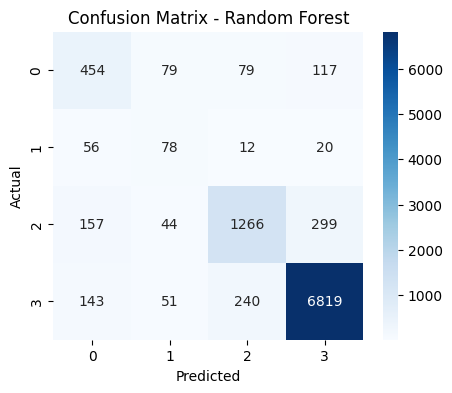


🔹 Decision Tree Model Performance
✅ Accuracy: 0.8951
✅ Precision: 0.8972, Recall: 0.8951, F1-Score: 0.8961
              precision    recall  f1-score   support

           0       0.65      0.68      0.67       729
           1       0.40      0.43      0.42       166
           2       0.80      0.81      0.80      1766
           3       0.96      0.95      0.95      7253

    accuracy                           0.90      9914
   macro avg       0.70      0.72      0.71      9914
weighted avg       0.90      0.90      0.90      9914



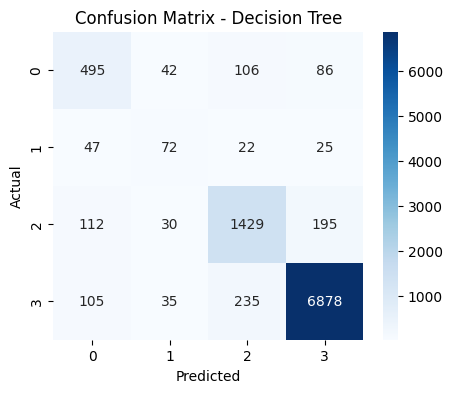


🔹 KNN Model Performance
✅ Accuracy: 0.8482
✅ Precision: 0.8826, Recall: 0.8482, F1-Score: 0.8594
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       729
           1       0.33      0.42      0.37       166
           2       0.68      0.86      0.76      1766
           3       0.99      0.87      0.92      7253

    accuracy                           0.85      9914
   macro avg       0.62      0.71      0.65      9914
weighted avg       0.88      0.85      0.86      9914



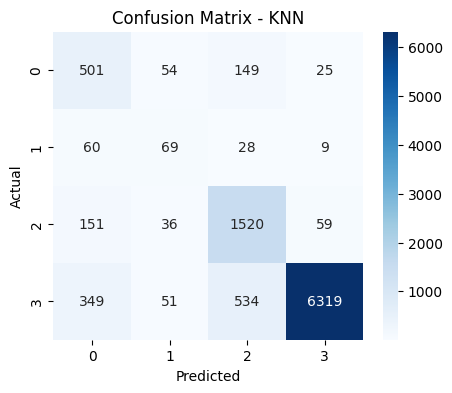


🔹 Naïve Bayes Model Performance
✅ Accuracy: 0.4420
✅ Precision: 0.7067, Recall: 0.4420, F1-Score: 0.5010
              precision    recall  f1-score   support

           0       0.17      0.40      0.24       729
           1       0.07      0.80      0.13       166
           2       0.34      0.56      0.42      1766
           3       0.86      0.41      0.55      7253

    accuracy                           0.44      9914
   macro avg       0.36      0.54      0.34      9914
weighted avg       0.71      0.44      0.50      9914



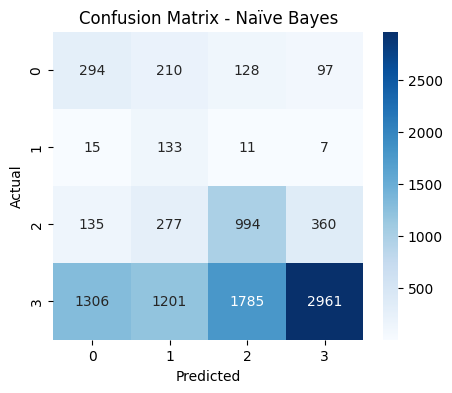


🔹 XGBoost Model Performance
✅ Accuracy: 0.9048
✅ Precision: 0.9163, Recall: 0.9048, F1-Score: 0.9092
              precision    recall  f1-score   support

           0       0.58      0.77      0.67       729
           1       0.48      0.58      0.53       166
           2       0.83      0.84      0.84      1766
           3       0.98      0.94      0.96      7253

    accuracy                           0.90      9914
   macro avg       0.72      0.78      0.75      9914
weighted avg       0.92      0.90      0.91      9914



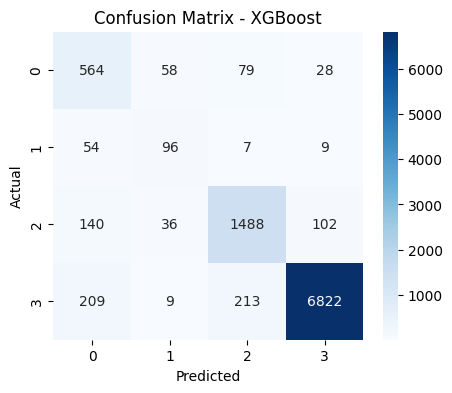


🔹 Stacking Model Model Performance
✅ Accuracy: 0.8932
✅ Precision: 0.9042, Recall: 0.8932, F1-Score: 0.8974
              precision    recall  f1-score   support

           0       0.58      0.74      0.65       729
           1       0.47      0.52      0.49       166
           2       0.79      0.83      0.81      1766
           3       0.97      0.93      0.95      7253

    accuracy                           0.89      9914
   macro avg       0.70      0.76      0.73      9914
weighted avg       0.90      0.89      0.90      9914



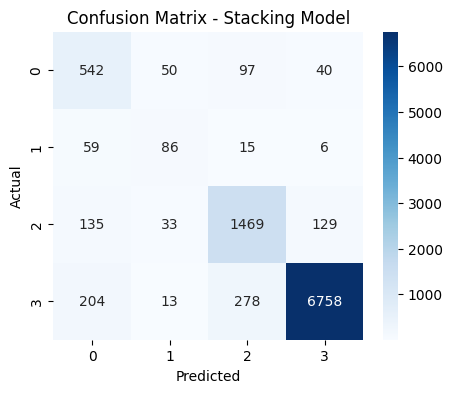


🔍 Model Performance Comparison:
                Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
Random Forest   0.869175   0.875234  0.869175  0.871468                NaN   
Decision Tree   0.895098   0.897169  0.895098  0.896080                NaN   
KNN             0.848194   0.882567  0.848194  0.859398                NaN   
Naïve Bayes     0.442001   0.706736  0.442001  0.501026                NaN   
XGBoost         0.904781   0.916275  0.904781  0.909171                NaN   
Stacking Model  0.893181   0.904197  0.893181  0.897446                NaN   

                Prediction Time (s)  
Random Forest              0.292152  
Decision Tree              0.049930  
KNN                       49.306886  
Naïve Bayes                0.010262  
XGBoost                    0.105764  
Stacking Model             0.219459  
💾 Model evaluation results saved to models/model_comparison.pkl


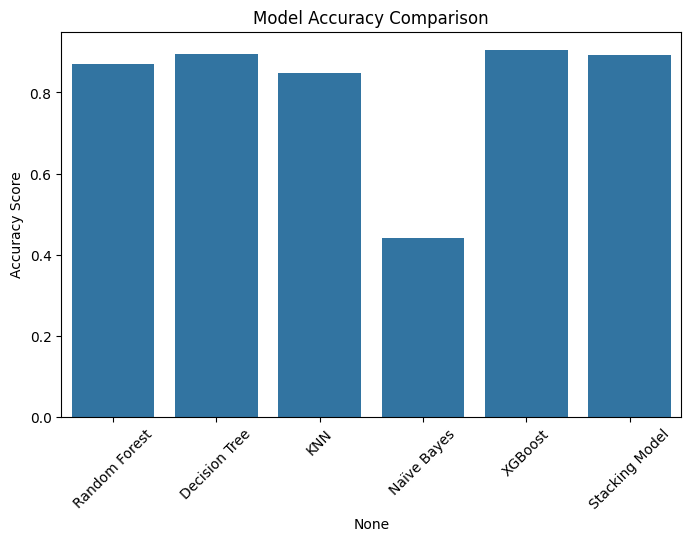

In [15]:
# 📌 Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import time
import os
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)

# ✅ Ensure the models directory exists
os.makedirs("models", exist_ok=True)

# 📌 Dictionary to store model evaluation results
model_results = {}

# 📌 Helper function to evaluate models and store results dynamically
def evaluate_model(model_name, model, X_test, y_test, retrain=False, X_train=None, y_train=None):
    """
    Evaluates a trained model, dynamically measures training time if retraining, 
    stores results, and displays classification report & confusion matrix.
    """

    # ✅ Train the model and measure training time if retraining is enabled
    if retrain and X_train is not None:
        start_time = time.time()
        model.fit(X_train, y_train)  # Train the model
        train_time = time.time() - start_time  # Compute training duration
    else:
        train_time = np.nan  # No retraining; mark training time as NaN

    # ✅ Start prediction timer
    start_pred_time = time.time()
    y_pred = model.predict(X_test)  # Generate predictions
    pred_time = time.time() - start_pred_time  # Compute prediction time

    # ✅ Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)

    # ✅ Store results in dictionary
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Training Time (s)": train_time,  # Timing is not working properly, use the timings for the individual models
        "Prediction Time (s)": pred_time
    }

    # ✅ Print classification report
    print(f"\n🔹 {model_name} Model Performance")
    target_names=list(label_mapping.keys()),  # Use original class names for readability
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # ✅ Compute and Plot the Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


# 📌 Load Saved Models (without Training Time)
rf_model = joblib.load("models/rf_model.pkl")
dt_model = joblib.load("models/dt_model.pkl")
knn_model = joblib.load("models/knn_model.pkl")
nb_model = joblib.load("models/nb_model.pkl")
xgb_model = joblib.load("models/xgb_model.pkl")
stacked_model = joblib.load("models/stacking_model.pkl")

# ✅ Evaluate Models (Dynamic Training Time Measurement)
evaluate_model("Random Forest", rf_model, X_test, y_test, retrain=False)
evaluate_model("Decision Tree", dt_model, X_test, y_test, retrain=False)
evaluate_model("KNN", knn_model, X_test, y_test, retrain=False)
evaluate_model("Naïve Bayes", nb_model, X_test, y_test, retrain=False)
xgb_model.set_params(early_stopping_rounds=True)
evaluate_model("XGBoost", xgb_model, X_test, y_test, retrain=False)
evaluate_model("Stacking Model", stacked_model, X_test, y_test, retrain=False)


# 📌 Convert results dictionary to DataFrame
results_df = pd.DataFrame(model_results).T  # Transpose for readability

print("\n🔍 Model Performance Comparison:")
print(results_df)  # Display the evaluation results

# ✅ Save evaluation results (excluding model timings)
joblib.dump(results_df, "models/model_comparison.pkl")
print("💾 Model evaluation results saved to models/model_comparison.pkl")

# 📌 Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x=results_df.index, y="Accuracy")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.show()



In [ ]:
# ✅ Import necessary libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone  # ✅ Ensures fresh instances of models
import numpy as np
import time
import joblib  # Load trained models

# ✅ Define Optimized 3-Fold Cross-Validation Strategy (Faster Execution)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 📌 Function to Perform Cross-Validation with Execution Timing
def perform_cross_validation(model, model_name, X_train, y_train):
    """
    Runs 3-fold cross-validation for the given model, tracks execution time,
    and prints accuracy with standard deviation.
    """
    print(f"\n🚀 Running Cross-Validation for {model_name}...")  # Notify start of validation

    start_time = time.time()  # Start timer for execution time tracking
    scores = cross_val_score(clone(model), X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)  # Run CV in parallel
    exec_time = time.time() - start_time  # Compute total execution time

    # ✅ Print Cross-Validation Results
    print(f"✅ {model_name} Cross-Validation Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")  
    print(f"⏳ {model_name} Cross-Validation Time: {exec_time:.2f} seconds")  # Display execution time

# 📌 Load Saved Models for Cross-Validation
rf_model = joblib.load("models/rf_model.pkl")
dt_model = joblib.load("models/dt_model.pkl")
knn_model = joblib.load("models/knn_model.pkl")
nb_model = joblib.load("models/nb_model.pkl")
xgb_model = joblib.load("models/xgb_model.pkl")
stacked_model = joblib.load("models/stacking_model.pkl")

# ✅ Fix XGBoost: Disable Early Stopping
xgb_model.set_params(early_stopping_rounds=None, n_jobs=-1)  # ✅ Runs XGBoost in parallel

# ✅ Run Cross-Validation for Each Model
perform_cross_validation(dt_model, "Decision Tree", X_train_balanced, y_train_balanced)
perform_cross_validation(nb_model, "Naïve Bayes", X_train_balanced, y_train_balanced)
perform_cross_validation(rf_model, "Random Forest", X_train_balanced, y_train_balanced)
perform_cross_validation(knn_model, "KNN", X_train_balanced, y_train_balanced)
perform_cross_validation(xgb_model, "XGBoost", X_train_balanced, y_train_balanced)

# ✅ Fix: Clone Stacking Model for Each Fold
print("\n🚀 Running Cross-Validation for Stacking Model...")
start_time = time.time()
stacked_cv_scores = cross_val_score(clone(stacked_model), X_train_balanced, y_train_balanced, cv=cv, scoring="accuracy", n_jobs=-1)
exec_time = time.time() - start_time  # Track execution time

print(f"✅ Stacking Model Cross-Validation Accuracy: {np.mean(stacked_cv_scores):.4f} ± {np.std(stacked_cv_scores):.4f}")
print(f"⏳ Stacking Model Cross-Validation Time: {exec_time:.2f} seconds")



🚀 Running Cross-Validation for Decision Tree...
✅ Decision Tree Cross-Validation Accuracy: 0.9540 ± 0.0023
⏳ Decision Tree Cross-Validation Time: 129.19 seconds

🚀 Running Cross-Validation for Naïve Bayes...
✅ Naïve Bayes Cross-Validation Accuracy: 0.5415 ± 0.0029
⏳ Naïve Bayes Cross-Validation Time: 1.55 seconds

🚀 Running Cross-Validation for Random Forest...
✅ Random Forest Cross-Validation Accuracy: 0.8881 ± 0.0011
⏳ Random Forest Cross-Validation Time: 71.70 seconds

🚀 Running Cross-Validation for KNN...
✅ KNN Cross-Validation Accuracy: 0.9500 ± 0.0009
⏳ KNN Cross-Validation Time: 183.92 seconds

🚀 Running Cross-Validation for XGBoost...
✅ XGBoost Cross-Validation Accuracy: 0.9562 ± 0.0006
⏳ XGBoost Cross-Validation Time: 2168.34 seconds

🚀 Running Cross-Validation for Stacking Model...


In [ ]:
!jupyter nbconvert --to script Untitled.ipynb --output total